In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

# Parte 1: Análisis exploratorio de datos (EDA)

##### 1. Carga los datos en Python y realiza una inspección inicial. ¿Qué tipos de datos hay en el conjunto de datos? ¿Hay algún valor perdido o atípico? 

In [2]:
stores = pd.read_csv('../data/rossmann-store-sales/store.csv')
train = pd.read_csv('../data/rossmann-store-sales/train.csv')
test = pd.read_csv('../data/rossmann-store-sales/test.csv')

In [3]:
print(stores.columns)
print(train.columns)
print(test.columns)

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')
Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')
Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday'],
      dtype='object')


Dentro del set de datos observamos que tenemos lo siguiente:
* **Train / Test** - Datos que contienen informacion de las ventas por dia de cada una de las tiendas, al igual que datos sobre si esos dias corren algunas promociones.
* **Store** - Información relevante de cada una de las tiendas como ubicacion, competidores, plan de promociones y "nivel" del inventario, entre otras caracteristicas.

In [4]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [5]:
train.info()
train['StateHoliday'] = train['StateHoliday'].astype(str)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [6]:
test.info()
test['StateHoliday'] = test['StateHoliday'].astype(str)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             41088 non-null  int64  
 1   Store          41088 non-null  int64  
 2   DayOfWeek      41088 non-null  int64  
 3   Date           41088 non-null  object 
 4   Open           41077 non-null  float64
 5   Promo          41088 non-null  int64  
 6   StateHoliday   41088 non-null  object 
 7   SchoolHoliday  41088 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


En cuanto los tipos de datos, observamos ligeras discrepancias de nuestro set de entrenamiento con el de validación, que tenemos que alinear para poder aseguar el correcto funcionamiento. Por ejemplo, dentro de nuestro set **train** tenemos el número de clientes el cual no se considera para ningun tipo de validacion.

In [7]:
print("Forma stores:",stores.shape)
print("Forma train:",train.shape)
print("Forma test:",test.shape)

print("% de set de validación")
print(round(test.shape[0]/(train.shape[0] + test.shape[0]) * 100,2))

Forma stores: (1115, 10)
Forma train: (1017209, 9)
Forma test: (41088, 8)
% de set de validación
3.88


Como tal en los datos vemos que el problema nos da un set de validaciones alrededor del 4% que ocuparemos para validar el modelo, aunque tenemos que separar el dataframe de **test** para poder entrenar y probar el modelo.

##### 2. Realiza un análisis estadístico inicial de los datos. ¿Cuál es el rango de las ventas? ¿Cuántas tiendas y productos diferentes hay en los datos? 

Número de tiendas: 1115
______________


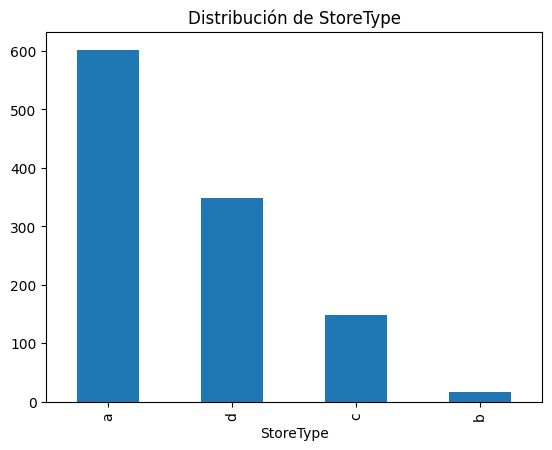

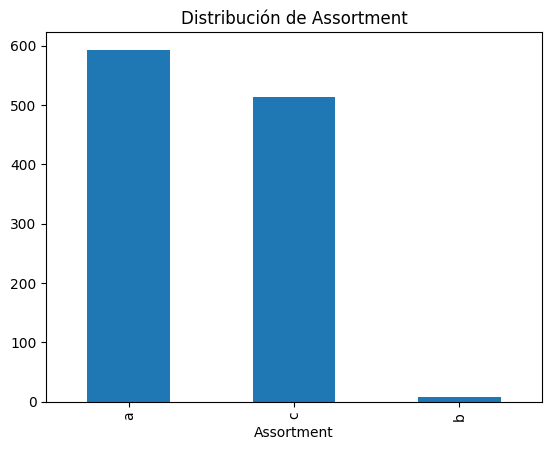

In [8]:
# Analisis de stores
print("Número de tiendas:", len(stores["Store"].unique()))

plt.figure()
stores["StoreType"].value_counts().plot(kind='bar')
plt.title("Distribución de StoreType")

plt.figure()
stores["Assortment"].value_counts().plot(kind='bar')
plt.title("Distribución de Assortment")

print("______________")

Número de tiendas: 1115
Rango de Sales: 41551
______________


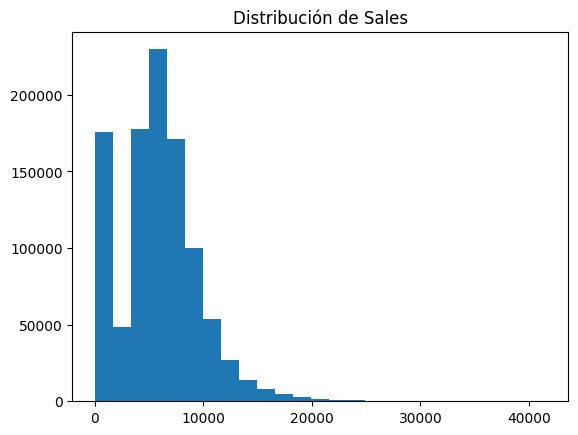

In [9]:
# Analisis de train
print("Número de tiendas:", len(train["Store"].unique()))
print("Rango de Sales:", train["Sales"].max() - train["Sales"].min())

plt.figure()
plt.hist(train["Sales"], bins=25)
plt.title("Distribución de Sales")

print("______________")

In [10]:
pd.options.display.float_format = '{:.2f}'.format
train["Sales"].describe()

count   1017209.00
mean       5773.82
std        3849.93
min           0.00
25%        3727.00
50%        5744.00
75%        7856.00
max       41551.00
Name: Sales, dtype: float64

Promedio de Ventas Totales: 5773.818972305593
______________


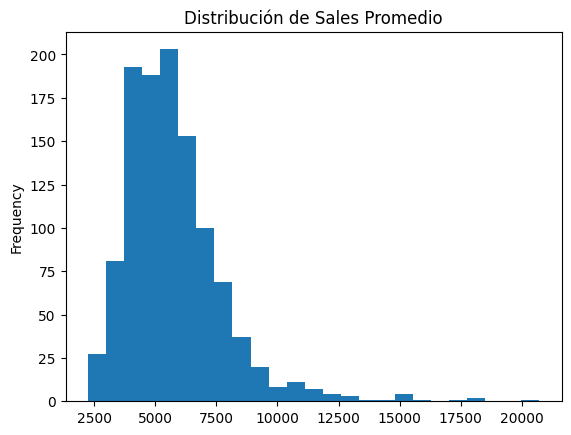

In [11]:
print("Promedio de Ventas Totales:",train["Sales"].mean())

average_sales = train.groupby("Store")["Sales"].mean()
plt.figure()
average_sales.plot(kind='hist', bins=25)
plt.title("Distribución de Sales Promedio")

print("______________")

Podemos observar a partir de la infomracion el tipod e tiendas e inventario que manejan tiene una distribucion indicando que no todas las tiendas venden lo mismo. Al momento de ponderar las ventas vemos que el rango esta desde los $0.00 a $41,551.00 unidades.

##### 3. ¿Cómo se distribuyen las ventas por tiendas? ¿Existen tiendas con comportamientos atípicos? ¿Qué podrían implicar estas anomalías? 

Text(0.5, 1.0, 'Distribución de Sales Promedio por Assortment')

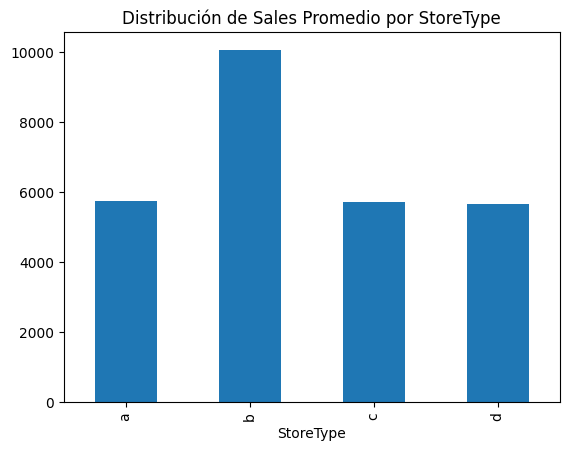

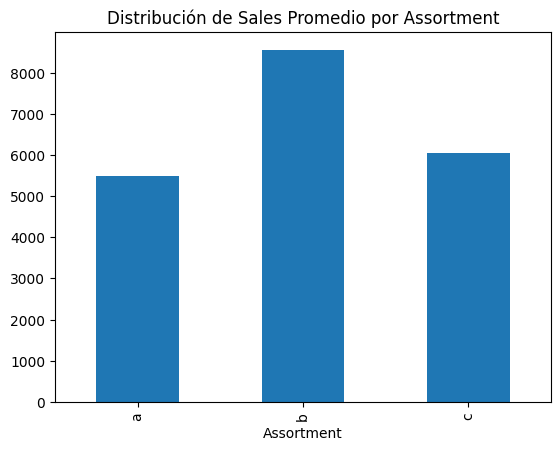

In [12]:
train_temp = train.merge(stores, on="Store")
average_sales_storetype = train_temp.groupby("StoreType")["Sales"].mean()
average_sales_assortment = train_temp.groupby("Assortment")["Sales"].mean()

plt.figure()
average_sales_storetype.plot(kind='bar')
plt.title("Distribución de Sales Promedio por StoreType")

plt.figure()
average_sales_assortment.plot(kind='bar')
plt.title("Distribución de Sales Promedio por Assortment")

Text(0.5, 1.0, 'Número de Outliers por Tienda (Top 10)')

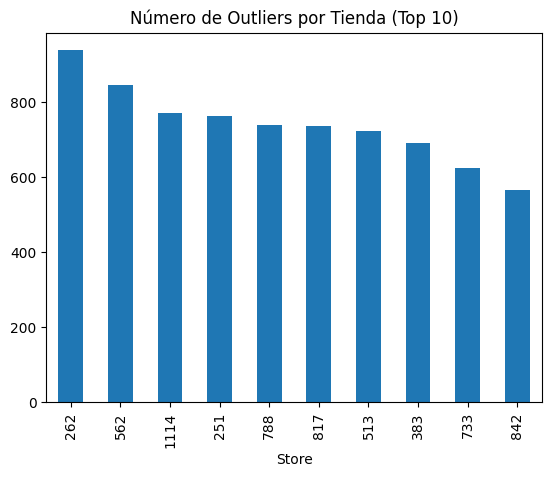

In [13]:
Q1 = train_temp["Sales"].quantile(0.25)
Q3 = train_temp["Sales"].quantile(0.75)
IQR = Q3 - Q1

outliers = train_temp[(train_temp["Sales"] < (Q1 - 1.5 * IQR)) | (train_temp["Sales"] > (Q3 + 1.5 * IQR))]

outliers["Store"].value_counts().head(10).plot(kind='bar')
plt.title("Número de Outliers por Tienda (Top 10)")


Text(0.5, 1.0, 'Sales vs Customers')

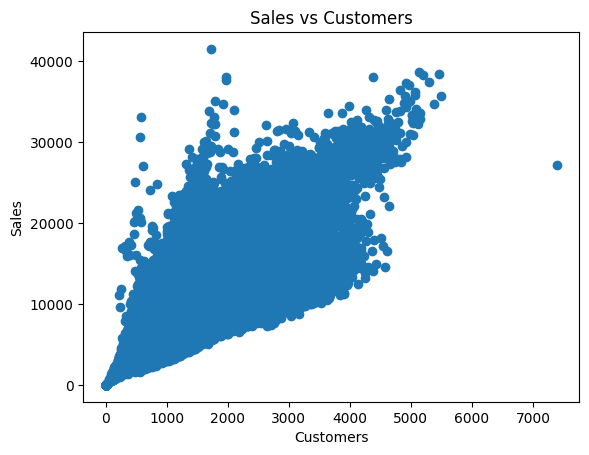

In [14]:
plt.figure()
plt.scatter(train["Customers"], train["Sales"])
plt.xlabel("Customers")
plt.ylabel("Sales")
plt.title("Sales vs Customers")

Dentro del top 10 de tiendas en anomalias se observa que hay algunas que tienen valores muy altos fuera de los cuartiles Q1 y Q3 que nos puede indicar que hay outliers. Tendríamos que visualizar los datos de las tiendas para entender si hay algun tema.  
Tambien vemos que hay un tipo de tienda con cierto inventarioq que llega a ser el más atractivo por el momento aunque se tiene que analizar mas a fondo la ubicacion de cada una de las tiendas parar poder localizar el por qué de estos outliers.  
Por ultimo cuando nos fijamos en la relacion del número de clientes y las ventas vemos que no hay un comportamiento lineal como tal pero necesitamos mayor detalle de esta relacion o seccionarla parap oder realizar un buen modelo.

##### 4. Visualiza las ventas a lo largo del tiempo para un par de tiendas. ¿Se observa alguna tendencia o patrón recurrente? 

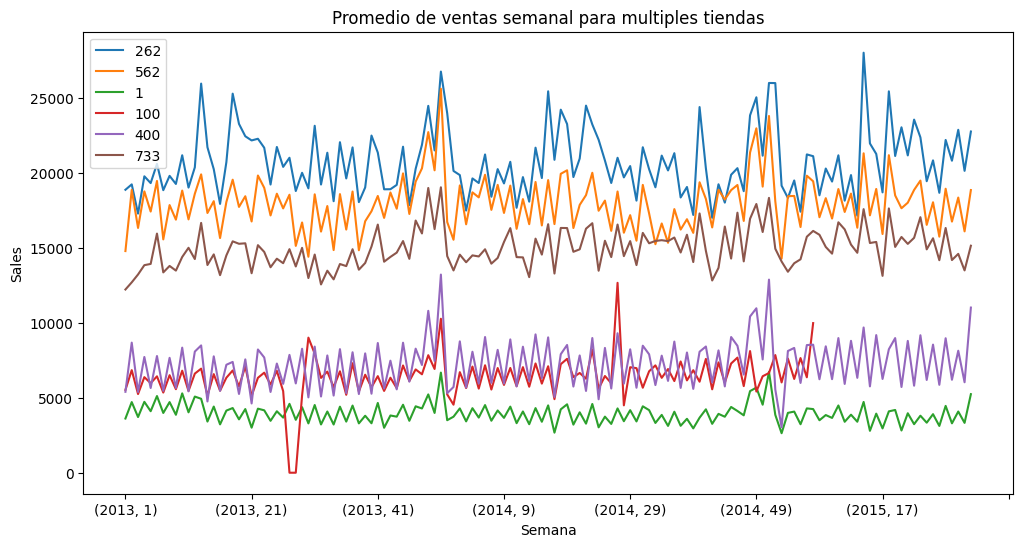

In [15]:

plt.figure(figsize=(12, 6))
store_list = [262, 562, 1, 100 , 400, 733]

for store in store_list:
    store_data = train[train["Store"] == store]
    store_data["Date"] = pd.to_datetime(store_data["Date"])
    store_data["Week"] = store_data["Date"].dt.isocalendar().week
    store_data["Year"] = store_data["Date"].dt.year

    weekly_sales = store_data.groupby(["Year", "Week"])["Sales"].mean()
    weekly_sales.plot(kind='line')

plt.title("Promedio de ventas semanal para multiples tiendas")
plt.xlabel("Semana")
plt.ylabel("Sales")
plt.legend(store_list)
plt.show()


Se logran observar ciertas anomalias dentro de las tiendas que tienen valores fuera del rango del Q1 y Q3. En especifico para las tiendas con mayor cantidad de anomalias se observan picos muy altos de temporalidad que pueden ser por ubicacion, promociones, competidores, etc. y tambien hay valores demasiado bajos que puede ser desde un cierre continuo por un lapso de tiempo.  
Podría decir que la temporalidad es claramente visible y se comparte en todas las tiendas pero hay picos interesantes que requireen un mayor análisis.

Text(0.5, 1.0, 'Ventas por día de la semana')

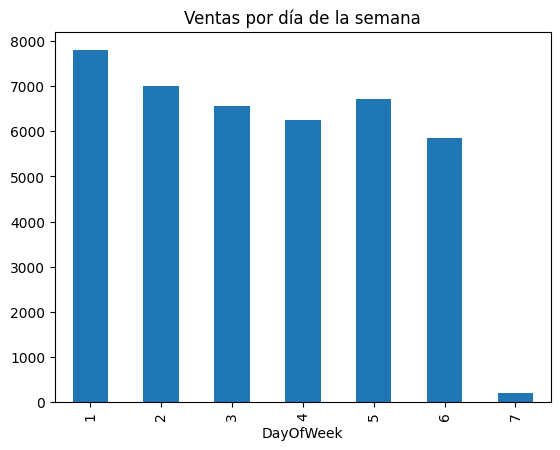

In [16]:
plt.figure()
train.groupby("DayOfWeek")["Sales"].mean().plot(kind='bar')
plt.title("Ventas por día de la semana")

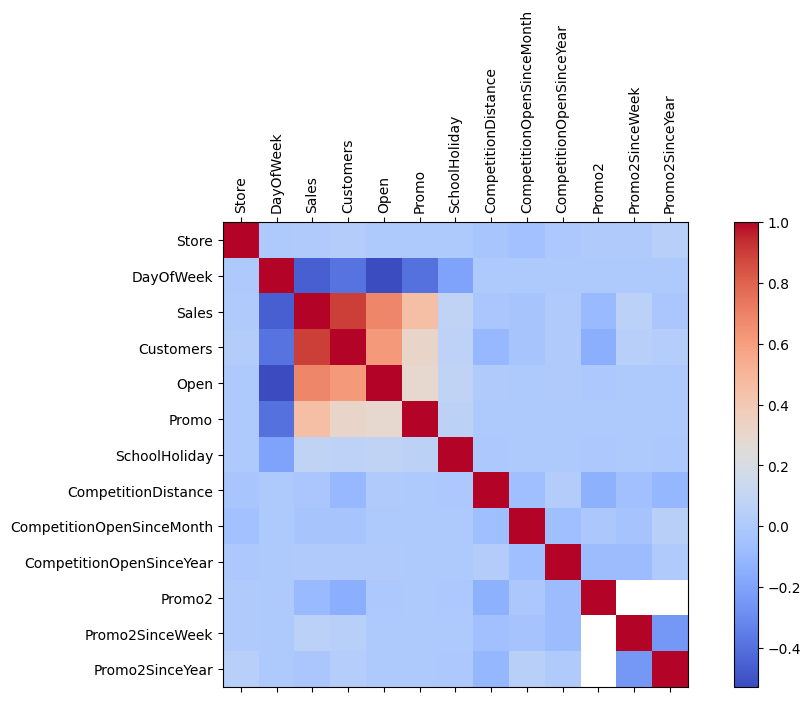

In [17]:
numeric_columns = train_temp.select_dtypes(include=np.number).columns
corr = train_temp[numeric_columns].corr()
plt.figure(figsize=(12, 6))
plt.matshow(corr, cmap='coolwarm', fignum=1)
plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.show()


##### 5. Con base en el análisis exploratorio, identifica las principales características que podrían afectar las ventas. Justifica tus elecciones.

1. La temporalidad es un factor muy importante para las ventas que se tiene que considerar al momento de realizar el modelo ya que enfocarnos en un solo snapshot de los datos puede generar un sesgo en la información. Esta temporalidad en este caso igual podría ir a mas detalle y ser hasta por dia de la semana.
2. El tipo de tienda e inventario es un factor importante que se tiene que tomar en cuenta ya que el hecho de la disponbilida de inventario, productos y la forma en la que éstos se ofrecen impacta el desempeño de la tienda y lo que deberiamos esperar de cada una.
3. Número de outliers en los sets, estos infliyen ya que tienen comportamiento distinto a los esperado por parte de las tiendas los cuales pueden estar mas alejados o ser mas dificil de modelar.

# Parte 2: Preprocesamiento de los datos y Ingeniería de Características

##### 6. ¿Cómo tratarías los valores perdidos y atípicos en los datos? Explica tu enfoque y las razones de tu elección. 

**Valores perdidos**:  
Estos se observan principalmente en las tablas de información de las tiendas, principalmente en las secciones de competidores y promociones. Con respecto a los competidores la informacion faltante es de la fecha de apertura, la cual inicialmente descartaria para el modelo ya que no podría tener una buena supocición del dato.  
Por la parte de promociones tendría de dos maneras, la primer opción sería descartar toda la columna, pero la segunda es poder aplicar promociones a nivel compañía, es decir, obtener por dia la promoción y observar si un % minimo de tiendas tiene promoción extender a todas las demás tiendas.

**Valores atípicos**:  
Para este caso tendría que desarrollar un cierto estandar de reglas a aplicar para poder estandarizar y decidir que hacer con los valores atipicos. Una estrategia sería eliminar completamente las tiendas que tengan mas del X% de sus ventas sean atípicas, ya que no refleja el comportamiento de la tienda promedio y son anomalias que necesitan estudiarse por si solas. Otro sería eliminar variables que causen ruido, como en este caso las ventas por día en el día 7 observamos que es completamente distinto a los demás por lo que sería data que pueda crear un sesgo.

##### 7. Realiza la ingeniería de características necesaria para mejorar el rendimiento del modelo. ¿Qué nuevas características podrías crear y por qué crees que serán útiles?

Tenemos que tener caracteristicas que ayuden a ligar la información de las tiendas con las de ventas. Factores como ubicación, fecha / día, tipod e tienda serían caracteristicas que tenemos que integrar al modelo para poder determinar el resultado de la predicción.  

**Nuevas Caracteristicas Sugeridas**:  
* Combinación entre Assortment y StoreType - Revisar combinación de inventarios conforme las tiendas.
* Location / Holidays - Poder definir horas especificas en las que podría haber outliers for mayor disponibilida de tiempo.
* Fechas Separadas - Para una mejor entendimiento de la temporalidad sería recomendable separar las fechas en día, mes y año para poder capturar la temporalidad de mejor manera.

##### 8. ¿Cómo garantizarías la calidad de los datos durante este proceso?

Se tiene que definir una estrategia de ingestion de datos o pipelines para poder determinar de la fuente de los datos y establecer un contrato sobre como se van a recibir para posteriormente crear pipelines con rule engines que permitan generar estos datos adicionales de manera eficiente.

# Parte 3 Modelado de Machine Learning

##### 9. Selecciona un modelo de aprendizaje automático adecuado para esta tarea de predicción. ¿Por qué elegiste este modelo? ¿Qué ventajas ofrece para este tipo de problemas?

En este caso algun metodo de Gradient Boosting seria el approach que buscaríamos para este set de datos. El motivo del por qué cual elijo este tipo de modelos es principalmente por la falta de evidencia para justificar un modelo de compoartamientos lineales y se necesita un acercamiento dinámico que pueda capturar, temporalidad, relaciones no lineales, flexibilidad para poder ajustar el modelo adecuadamente.  
Las ventajas a comparación de los modelos tradicionales es que el gradient boosting permite capturar ciertas particularidades de cada punto en este caso tiendas que permiten mantener la particularidad de cada tienda.

##### 10. Divide los datos en un conjunto de entrenamiento y un conjunto de pruebas. ¿Cómo te asegurarías de que la división refleja cualquier estructura temporal en los datos?

In [18]:
train = pd.merge(train, stores, on="Store")
test = pd.merge(test, stores, on="Store")

train["Date"] = pd.to_datetime(train["Date"])
test["Date"] = pd.to_datetime(test["Date"])

X_train = train.drop(["Store", "Sales", "Customers"], axis=1)
y_train = train["Sales"]

ts_split = TimeSeriesSplit(n_splits=5)

for i, (train_index, valid_index) in enumerate(ts_split.split(X_train)):
    print("Set", i+1, "Train Index:", train_index, "Validation Index:", valid_index)
    print("Set", i+1, "Train Dates:", X_train.iloc[train_index]["Date"].min(), X_train.iloc[train_index]["Date"].max())
    print("Set", i+1, "Validation Dates:", X_train.iloc[valid_index]["Date"].min(), X_train.iloc[valid_index]["Date"].max())
    print("______________")

Set 1 Train Index: [     0      1      2 ... 169536 169537 169538] Validation Index: [169539 169540 169541 ... 339070 339071 339072]
Set 1 Train Dates: 2015-03-01 00:00:00 2015-07-31 00:00:00
Set 1 Validation Dates: 2014-09-13 00:00:00 2015-03-01 00:00:00
______________
Set 2 Train Index: [     0      1      2 ... 339070 339071 339072] Validation Index: [339073 339074 339075 ... 508604 508605 508606]
Set 2 Train Dates: 2014-09-13 00:00:00 2015-07-31 00:00:00
Set 2 Validation Dates: 2014-04-02 00:00:00 2014-09-13 00:00:00
______________
Set 3 Train Index: [     0      1      2 ... 508604 508605 508606] Validation Index: [508607 508608 508609 ... 678138 678139 678140]
Set 3 Train Dates: 2014-04-02 00:00:00 2015-07-31 00:00:00
Set 3 Validation Dates: 2013-11-01 00:00:00 2014-04-02 00:00:00
______________
Set 4 Train Index: [     0      1      2 ... 678138 678139 678140] Validation Index: [678141 678142 678143 ... 847672 847673 847674]
Set 4 Train Dates: 2013-11-01 00:00:00 2015-07-31 00:0

Por medio de un split de series de tiempo es lo que ocupamos ya que si lo hacemos de manera aleatoria, puede que no se capture de manera correcta los comportamientos de temporalidad y la validación no pueda ser aplicable en el largo plazo.  
Si observamos en este caso los sets que se generan son super-sets que abarcan los pasados para mantener los comportamientos.

##### 11. Entrena el modelo en el conjunto de entrenamiento. Ajusta los hiperparámetros del modelo para mejorar su rendimiento. ¿Cómo optimizarías este proceso?

In [19]:
models = []
for train_index, valid_index in ts_split.split(X_train):
    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[valid_index]

    X_tr["StateHoliday"] = X_tr["StateHoliday"].astype("category")
    X_tr["StoreType"] = X_tr["StoreType"].astype("category")
    X_tr["Assortment"] = X_tr["Assortment"].astype("category")
    X_tr["PromoInterval"] = X_tr["PromoInterval"].astype("category")

    X_val["StateHoliday"] = X_val["StateHoliday"].astype("category")
    X_val["StoreType"] = X_val["StoreType"].astype("category")
    X_val["Assortment"] = X_val["Assortment"].astype("category")
    X_val["PromoInterval"] = X_val["PromoInterval"].astype("category")

    dtrain = xgb.DMatrix(X_tr.drop(["Date"], axis=1), y_tr, enable_categorical=True)
    dvalid = xgb.DMatrix(X_val.drop(["Date"], axis=1), y_val, enable_categorical=True)
    
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    params = {
        'objective': 'reg:squarederror',
        'eta': 0.6,
        'max_depth': 0,
        'subsample': 0.5,
        'colsample_bytree': 0.6,
        'eval_metric': 'rmse',
        'seed': 0
    }

    model = xgb.train(params, dtrain, 1000, watchlist, maximize=False, early_stopping_rounds = 50, verbose_eval=50)

    models.append(model)

[0]	train-rmse:2464.92777	eval-rmse:2593.41979
[50]	train-rmse:868.88292	eval-rmse:1390.79789
[61]	train-rmse:868.40020	eval-rmse:1393.40551
[0]	train-rmse:2520.76440	eval-rmse:2431.02568
[50]	train-rmse:1082.65062	eval-rmse:1094.63920
[56]	train-rmse:1082.71537	eval-rmse:1093.27961
[0]	train-rmse:2485.44551	eval-rmse:2659.28489
[50]	train-rmse:1047.27386	eval-rmse:1410.06221
[100]	train-rmse:1047.59300	eval-rmse:1412.87080
[101]	train-rmse:1047.60273	eval-rmse:1412.95866
[0]	train-rmse:2517.48862	eval-rmse:2286.65601
[50]	train-rmse:1122.69463	eval-rmse:1183.83418
[53]	train-rmse:1122.62540	eval-rmse:1182.93025
[0]	train-rmse:2481.67578	eval-rmse:2399.64817
[50]	train-rmse:1111.70277	eval-rmse:1139.93410
[100]	train-rmse:1111.47838	eval-rmse:1139.15854
[150]	train-rmse:1111.17741	eval-rmse:1139.70937
[165]	train-rmse:1111.60173	eval-rmse:1139.61400


La manera en la que podemos optimizar el proceso es por medio de las metricas que podemos obtener del set de entrenamiento como tal. Es decir, del split que hicimos para la validación calculamos los residuales para buscar minimizar estos sin llegara extremos de overfitting.

# Parte 4: Evaluación del Modelo y Optimización

##### 12. Evalúa el rendimiento del modelo en el conjunto de prueba. ¿Cómo de preciso es el modelo? ¿Cómo varía el rendimiento a lo largo del tiempo y entre diferentes tiendas?

In [20]:
train["StateHoliday"] = train["StateHoliday"].astype("category")
train["StoreType"] = train["StoreType"].astype("category")
train["Assortment"] = train["Assortment"].astype("category")
train["PromoInterval"] = train["PromoInterval"].astype("category")

dtrain = xgb.DMatrix(train.drop(["Store", "Date", "Sales", "Customers"], axis=1), enable_categorical=True)

predictions =[]
for model in models:
    predictions.append(model.predict(dtrain))

predictions = np.mean(predictions, axis=0)

RMSE: 1152.9443037218216


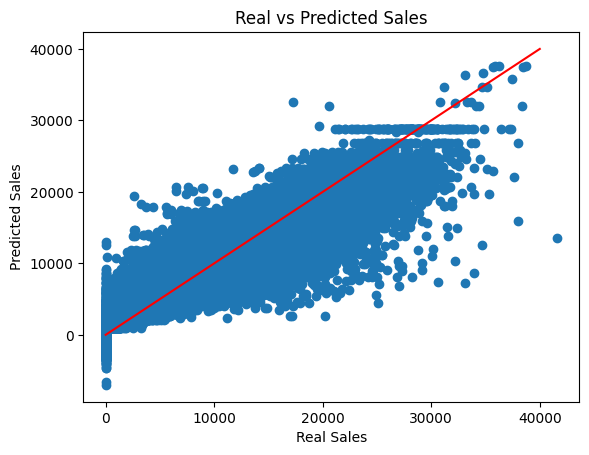

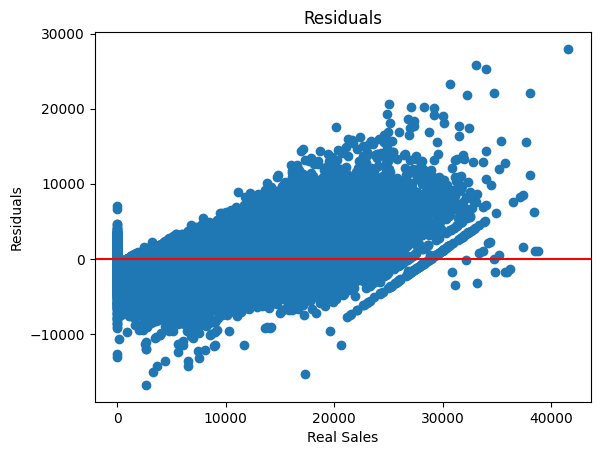

In [21]:
rmse = np.sqrt(mean_squared_error(y_train, predictions))
print("RMSE:", rmse)

plt.figure()
plt.scatter(y_train, predictions)
plt.plot([0, 40000], [0, 40000], color='red')
plt.xlabel("Real Sales")
plt.ylabel("Predicted Sales")
plt.title("Real vs Predicted Sales")

plt.figure()
plt.scatter(y_train, y_train - predictions)
plt.axhline(0, color='red')
plt.xlabel("Real Sales")
plt.ylabel("Residuals")
plt.title("Residuals")

plt.show()


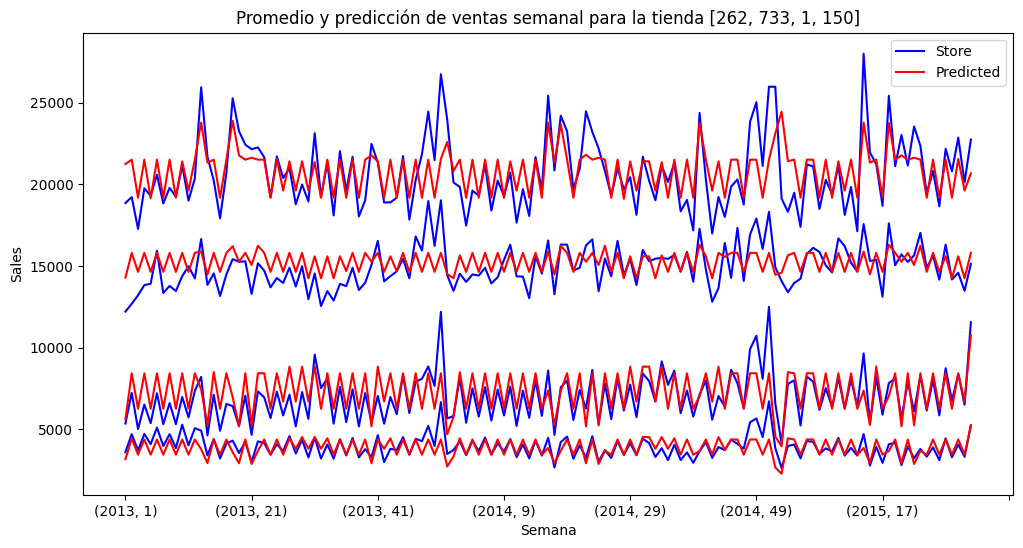

In [22]:
plt.figure(figsize=(12, 6))
store_list = [262, 733, 1, 150]

for store in store_list:
    store_data = train[train["Store"] == store]
    store_data["Date"] = pd.to_datetime(store_data["Date"])
    store_data["Week"] = store_data["Date"].dt.isocalendar().week
    store_data["Year"] = store_data["Date"].dt.year
    store_data["PredictedSales"] = predictions[train["Store"] == store]

    weekly_sales = store_data.groupby(["Year", "Week"])["Sales"].mean()
    weekly_predicted_sales = store_data.groupby(["Year", "Week"])["PredictedSales"].mean()

    weekly_sales.plot(kind='line', color='blue')
    weekly_predicted_sales.plot(kind='line', color='red')

plt.title(f"Promedio y predicción de ventas semanal para la tienda {store_list}")
plt.xlabel("Semana")
plt.ylabel("Sales")
plt.legend(["Store", "Predicted"])
plt.show()


El modelo aun tiene oportunidades, de primer instancia observamos como captura ciertas temporalidades de maner correcta pe pero en los casos con las tiendas con mayor numero de outliers faltan ajustes para lograr replicar el comportamiento.  
Gracias a que tomamos en cuentra las series de tiempo  podemos ver como a lo largo de toda la proyección se ve como la tendencia se respeta.  
Por otra parte en terminos de evaluación del modelo vemos como los residuales no tienen una distribución al asar que sería lo ideal vemos que no se respeta del todo pero gracias al modelo que empleamos esto puede ser un detalle donde tenemos que revisitas los parametros del modelo.

##### 13. ¿Qué métricas utilizarías para evaluar el modelo? ¿Por qué elegiste estas métricas?

Para este caso utilizaria Root Mean Squared Error (RMSE) ya que al hablar de dinero permite dimensionar la diferencia de la estimacion con las de las proyecciones. 
En este caso la elijo ya que mientras mas error tenga el modelo se penaliza de manera mas severa y permite ajustar de una mejor manera para casos promedio.

##### 14. ¿Cómo mejorarías el modelo si tuvieras más tiempo o recursos? ¿Qué otros modelos o técnicas podrías probar? 

Buscaría la manera de segmentar el modelo de acuerdo a las caracteristicas de las tiendas, intentar encontrar el insight en un solo modelo tiende a sacrificar particularidades que cada sector de tiendas pueda tener. El objetivo sería poder explicar por qué la varianza de cada tipo de tienda, para este modelo el hecho de que se mezclen los outliers de todas las tiendas puede llegar a generar un sesgo donde las tiendas con mayor cantidad de outliers tengan un peso mayor a un caso común generando mayor cantida de ruido. Al final lo que buscaria con mayores recursos es tener distintos modelos dependiendo del tipo de tienda y acceso a distintos recursos, y por distintos modelos dependiendo a las caracteristicas sería el tipo de acercamiento sea con Boosting u otros metodos que sean mas adecuados como Prophet o hasta regresiones simples para casos muy promedio.

# Parte 5: Interpretación y Comunicación de Resultados

##### 15. ¿Qué características son las más importantes para la predicción de las ventas? ¿Cómo interpretas estos resultados? 

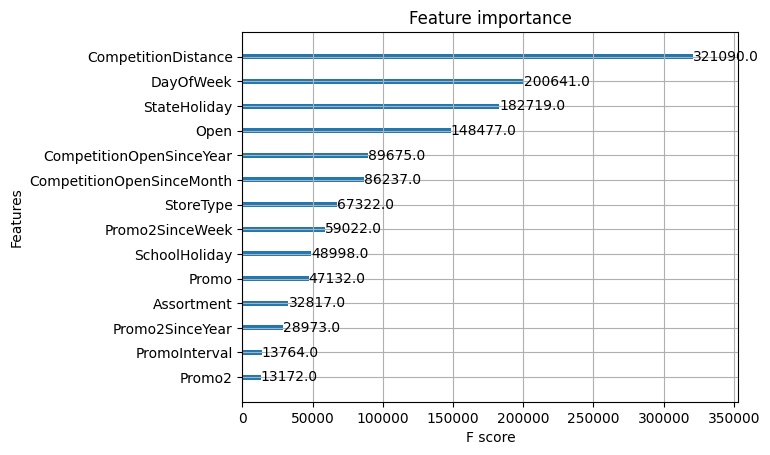

In [23]:
xgb.plot_importance(model)
plt.show()

Las caracteristicas mas importantes en este caso sería la distancia de un competidor, el día de la semana y los días feriados estatales serian el top 3 factores.
La interpretación seria que estos factores impactan substancialmente en las ventas por lo que se debe procurar tener las condiciones adecuadas para poder incrementar las ventas.  

##### 16. Basándote en los resultados del análisis, ¿qué acciones recomendarías a la dirección de la empresa para aumentar las ventas?

Mi recomendación seria evaluar los siguientes puntos:
* Evaluar competencia y estrategia de localización de tiendas para maximizar eficiencia de puntos de venta
* Revisar estrategia de inventarios semanales y anuales para estar preparados en días clave para incremento de ventas y mejorar experiencia de consumo para clientes.

##### 17. ¿Cómo te asegurarías de que los resultados del análisis sean utilizados eficazmente por los demás departamentos de la empresa?

Primero necesitaría conocer el contexto de los departamentos de la empresa para entender de mejor manera el tipo de insight que quieran generar.  
De primera instancia por medio de dashboards seria una manera visual para los equipos poder entender los datos y prepararse adecuadamente. Ahora que si lo que se quisieran consultar los datos, la recomendación sería generar reportes automatizado desde archivos CSV, PDF, etc. para personas que asi lo prefieran o una API que pueda ser consultada por equipos con mayor experiencia con la herramienta, buscando adaptar la solución lo mejor posible a la necesidad del stakeholder.

##### 18. Supongamos que tienes que presentar los resultados del análisis a un público no técnico. ¿Cómo comunicarías tus hallazgos de una manera clara y convincente? 

Lo primero sería entender el motivo de interés del público, para un caso no técnico prefiero mantener la comunicación alineada con el beneficio para negocio y los insights como temas accionables. En este caso especifico, buscaría hacer highlight en los siguientes temas:
* Cual es el objetivo del modelo ? Qué clase de beneficios trae ? (económicos, estrategicos, cadena de suministro, etc.)
* Requisitos y consideraciones para que el modelo funcione correctamente (datos, información, infraestructura, etc.)
* Mejora continua y actividades accionables inmediatos y a futuro.
* Mantener canales de comunicación para continuar el desarrollo y retroalimentación si los equipo quisieran detalles tecnicos con sus respectivas áreas.

##### 19. ¿Qué estrategias implementarías para mantener el modelo actualizado y garantizar que continúe proporcionando predicciones precisas a medida que llegan nuevos datos?

Primeramente tendría que alinear la estrategia de entrenamiento, si las prediciones se hacen con poca frecuencia podriamos crear pipelines de reentrenamiento integrando los datos acumulados. Estos pipelines se le pueden integrar ciertos triggers como una baja en precisión puede llevar a un reentrenamiento.  
Si las prediciones se requiren de manera frecuente cambiaría a un sistema de aprendizaje incremental, donde conforme se va alimentando los datos en tiempo real, se integran por lo que ocupamos el modelo previamente para entrenar con los nuevos datos y capturar los cambios y comportamientos de los datos mas recientes. Una estrategia de continuidad y monitoreo es necesario ser implementada ya que si tenemos algun tipo de cambio drastico en los datos este acercamiento puede fallar y necesitamos ajustar.